# Using the Python API 

<a target="_blank" href="https://colab.research.google.com/github/RobbinBouwmeester/Workshop_Grenoble_2025/blob/main/in-depth-python-api.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip install plotly ms2rescore==3.1.4 im2deep==1.0.2 psm_utils

In [13]:
import logging
import plotly.io
import os
import requests
import tarfile

logging.basicConfig(level=logging.INFO)
plotly.io.renderers.default = "plotly_mimetype+notebook"

## Reading and parsing peptide-spectrum matches

In [5]:
from psm_utils.io import read_file

from ms2rescore.report.charts import score_histogram

In [19]:
import urllib.request

url = "https://ftp.pride.ebi.ac.uk/pride/data/archive/2014/06/PXD001077/Velos005137.mgf"
output_path = "Velos005137.mgf"

urllib.request.urlretrieve(url, output_path)
print(f"Downloaded to: {output_path}")

Downloaded to: Velos005137.mgf


In [20]:
url = "https://rest.uniprot.org/uniprotkb/stream?format=fasta&query=%28%28proteome%3AUP000005640%29+AND+reviewed%3Dtrue%29"
output_path = "human.fasta"

urllib.request.urlretrieve(url, output_path)
print(f"Downloaded to: {output_path}")

Downloaded to: human.fasta


In [21]:
url = "https://raw.githubusercontent.com/HaoGroup-ProtContLib/Protein-Contaminant-Libraries-for-DDA-and-DIA-Proteomics/refs/heads/main/Universal%20protein%20contaminant%20FASTA/0602_Universal%20Contaminants.fasta"
output_path = "crap.fasta"

urllib.request.urlretrieve(url, output_path)
print(f"Downloaded to: {output_path}")

Downloaded to: crap.fasta


In [22]:
from pathlib import Path

# Define input and output file paths
human_fasta = Path("human.fasta")
crap_fasta = Path("crap.fasta")
merged_fasta = Path("merged.fasta")

# Read and write files
with open(merged_fasta, 'w') as outfile:
    for fasta in [human_fasta, crap_fasta]:
        with open(fasta, 'r') as infile:
            for line in infile:
                outfile.write(line)

print(f"Merged FASTA written to: {merged_fasta}")

Merged FASTA written to: merged.fasta


In [23]:
# Define URL and file paths
url = "https://github.com/lazear/sage/releases/download/v0.14.7/sage-v0.14.7-x86_64-unknown-linux-gnu.tar.gz"
archive_path = "sage-v0.14.7-x86_64-unknown-linux-gnu.tar.gz"
extract_dir = "./"

# Step 1: Download the file
print("Downloading archive...")
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open(archive_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

print(f"Downloaded archive to: {archive_path}")

# Step 2: Extract the tar.gz file
print("Extracting archive...")
with tarfile.open(archive_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)

print(f"Extracted to directory: {extract_dir}")

bin_sage_loc = "sage-v0.14.7-x86_64-unknown-linux-gnu/sage"

Downloaded archive to: sage-v0.14.7.tar.gz
Extracting archive...
Extracted to directory: ./


In [ ]:
import os

# Set the path to your executable file
file_path = 'sage-v0.14.7-aarch64-unknown-linux-gnu/sage'

# Set executable permission (equivalent to chmod +x)
os.chmod(file_path, os.stat(file_path).st_mode | 0o111)

### Reading the PSM file

MS²Rescore is fully centered around the use of a `psm_utils` PSMList. This is a unified data representation of PSMs and their various attributes. Internally, it is simply a list of Pydantic data classes which represent PSMs. With the submodule `psm_utils.io`, we can read PSMs from a variety of file formats. Here, we will read a PSM file in the MaxQuant `msms.txt` format.

Importantly, for rescoring, the PSM file must contain all target and decoy PSMs, including PSMs that did not pass the FDR threshold. Most search engines must be specifically configured to return all PSMs without FDR filtering.


In [3]:
psm_list = read_file("../../../examples/id/msms.txt", filetype="msms")
psm_list["spectrum_id"] = [str(spec_id) for spec_id in psm_list["spectrum_id"]]

For a quick inspection, we can format the PSM list as a Pandas dataframe and display the first few rows:

In [4]:
psm_list.to_dataframe().head()

peptidoform spectrum_id  \
0                      AAAAAAALQAK/2        4703   
1   [ac]-AAAAAEQQQFYLLLGNLLSPDNVVR/3       13572   
2  [ac]-AAAAAEQQQFYLLLGNLLSPDNVVRK/3       13366   
3                   AAAAAQGGGGGEPR/2         505   
4            AAAAAWEEPSSGN[de]GTAR/2        6589   

                                                 run collection spectrum  \
0  20161213_NGHF_DBJ_SA_Exp3A_HeLa_1ug_7min_15000_02       None     None   
1  20161213_NGHF_DBJ_SA_Exp3A_HeLa_1ug_7min_15000_02       None     None   
2  20161213_NGHF_DBJ_SA_Exp3A_HeLa_1ug_7min_15000_02       None     None   
3  20161213_NGHF_DBJ_SA_Exp3A_HeLa_1ug_7min_15000_02       None     None   
4  20161213_NGHF_DBJ_SA_Exp3A_HeLa_1ug_7min_15000_02       None     None   

   is_decoy    score qvalue       pep  precursor_mz  retention_time  \
0     False  107.660   None  0.001517     478.77982          5.2007   
1     False  107.740   None  0.004931     915.15197         11.8470   
2     False  137.890   None  0.000493     957.85029         11.6900   
3     False   22.641   None  0.142020     585.28653          0.5178   
4     False   89.403   None  0.046504     823.87389          6.6105   

  ion_mobility                      protein_list  rank source  \
0         None          [P36578, H3BM89, H3BU31]  None   msms   
1         None  [O00410, E7ETV3, E7EQT5, C9JZD8]  None   msms   
2         None  [O00410, E7ETV3, E7EQT5, C9JZD8]  None   msms   
3         None          [E9PJF0, E9PQW4, P27361]  None   msms   
4         None                          [Q9P258]  None   msms   

                                     provenance_data  \
0  {'msms_filename': '..\..\..\examples\id\msms.t...   
1  {'msms_filename': '..\..\..\examples\id\msms.t...   
2  {'msms_filename': '..\..\..\examples\id\msms.t...   
3  {'msms_filename': '..\..\..\examples\id\msms.t...   
4  {'msms_filename': '..\..\..\examples\id\msms.t...   

                                            metadata rescoring_features  
0  {'Scan index': '3698', 'Sequence': 'AAAAAAALQA...                 {}  
1  {'Scan index': '11885', 'Sequence': 'AAAAAEQQQ...                 {}  
2  {'Scan index': '11695', 'Sequence': 'AAAAAEQQQ...                 {}  
3  {'Scan index': '419', 'Sequence': 'AAAAAQGGGGG...                 {}  
4  {'Scan index': '5439', 'Sequence': 'AAAAAWEEPS...                 {}

We can also directly plot the current PSM score distributions:

In [5]:
score_histogram(psm_list)

### Parsing modification names

While `psm_utils` could take care of all file parsing, we must still map the amino acid modification names that were used by the search engine to ones that are recognized by tools such as MS²PiP and DeepLC. This includes:

- Names as used in the Unimod or PSI-MOD databases
- Accession numbers as used in the Unimod or PSI-MOD databases
- Chemical formulas
- Mass shifts in Da

Note that, for instance DeepLC, requires a chemical formula to encode modifications. It will not be able to correctly encode modifications if only the mass shift is provided. It is therefore always preferred to provide a name/accession of a database where this information can be retrieved, or provide the chemical formula directly.

If a chemical formula is provided, other tools, such as MS²PIP, can use it to derive the correct mass shift.

To map modification names, simply provide a dictionary to the `psm_list.map_modifications` method.

In [6]:
psm_list.rename_modifications({
    "gl": "Gln->pyro-Glu",
    "ox": "Oxidation",
    "ac": "Acetylation",
    "de": "Deamidation",
})

### Assigning fixed modifications

Some search engines (although not many) do not report fixed (sometimes also called static) modifications in their output PSM files. This is for instance the case for MaxQuant. With the method `psm_list.add_fixed_modifications`, we can systematically assign fixed modifications to their amino acid targets, as was done during the search. 

Note that `add_fixed_modifications` adds the modification in the ProForma 2.0 encoding as a prefix. To fully apply the modifications in the sequence, use the `psm_list.apply_fixed_modifications` method. A PSM `ACDE/2` would therefore go from `<[U:4]@C>ACDE/2` to `AC[U:4]DE/2`.



In [7]:
psm_list.add_fixed_modifications([("U:Carbamidomethyl", ["C"])])
psm_list.apply_fixed_modifications()

## Adding rescoring features

In [8]:
import pandas as pd

from ms2rescore.feature_generators.basic import BasicFeatureGenerator
from ms2rescore.feature_generators.maxquant import MaxQuantFeatureGenerator
from ms2rescore.feature_generators.ms2pip import MS2PIPFeatureGenerator
from ms2rescore.feature_generators.deeplc import DeepLCFeatureGenerator

The PSM list, as read from a MaxQuant msms.txt file, currently does not contain any rescoring features:

In [9]:
pd.DataFrame(list(psm_list["rescoring_features"]))

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[35556 rows x 0 columns]

Note that `psm_list[rescoring_features]` returns a Numpy array of dictionaries, but we can use Pandas to format it as a table. 

### Basic features

Basic features from `BasicFeatureGenerator` can be added from any PSM list and contain simple feature, such as the search engine score, charge state, and absolute precursor mass error.

In [10]:
basic_fgen = BasicFeatureGenerator()
basic_fgen.add_features(psm_list)

INFO:ms2rescore.feature_generators.basic:Adding basic features to PSMs.


In [11]:
pd.DataFrame(list(psm_list["rescoring_features"]))

charge_n  charge_1  charge_2  charge_3  charge_4  charge_5  charge_6  \
0             2         0         1         0         0         0         0   
1             3         0         0         1         0         0         0   
2             3         0         0         1         0         0         0   
3             2         0         1         0         0         0         0   
4             2         0         1         0         0         0         0   
...         ...       ...       ...       ...       ...       ...       ...   
35551         2         0         1         0         0         0         0   
35552         4         0         0         0         1         0         0   
35553         2         0         1         0         0         0         0   
35554         3         0         0         1         0         0         0   
35555         3         0         0         1         0         0         0   

       charge_7  abs_ms1_error_ppm  search_engine_score  
0             0           1.137810             107.6600  
1             0           0.598941             107.7400  
2             0           0.573291             137.8900  
3             0           0.929236              22.6410  
4             0           0.666129              89.4030  
...         ...                ...                  ...  
35551         0           0.782088              76.1000  
35552         0           1.147761             114.6400  
35553         0           0.813101              43.1240  
35554         0           0.719097              23.5620  
35555         0           1.083807               9.1885  

[35556 rows x 10 columns]

Now the PSMs contain a simple set of features.

Note that the charge state is present as both an integer and a one-hot encoded vector. This is because charge state can act as both a categorical and a numerical feature. Simply put, sometimes an effect increases or decreases with increasing charge state, and sometimes it is simply different for different charge states.

### MS²PIP features

MS²PIP is a machine learning tool that predicts the MS2 spectrum of a peptide given its sequence. It is previously identified MS2 spectra and their corresponding peptide sequences. Because MS²PIP uses the highly performant - but traditional - machine learning approach XGBoost, it can already produce accurate predictions even if trained on smaller spectral libraries. This makes MS²PIP a very flexible platform to train new models on custom datasets. Nevertheless, MS²PIP comes with several pre-trained models, which we will use in this tutorial.

Because traditional proteomics search engines do not fully consider MS2 peak intensities in their scoring functions, adding rescoring features derived from spectrum prediction tools has proved to be a very effective way to further improve the sensitivity of peptide-spectrum matching. Generating features from MS²PIP predictions follows these steps:

1. Predict MS2 spectra for all PSMs in the dataset, including decoy PSMs and low scoring target PSMs.
2. Read and parse the observed MS2 spectra from the original spectrum files (MGF or mzML).
3. Compare the predicted and observed spectra using various similarity metrics, which are returned as rescoring features.


#### Configuring MS²PIP

In contrast to the basic feature generator, MS²PIP requires some parameters to be set and requires access to the original observed peptide spectra:

- `model`: Name of the prediction model to be used. This strongly depends on the dataset your are rescoring. A list of all MS²PIP models is available on https://ms2pip.readthedocs.io/en/latest/prediction-models/. 
- `ms2_tolerance`: As MS²PIP must reannotate the observed MS2 spectra, a mass tolerance must be set. For MS²PIP, this is configured in Dalton. A good value for Orbitrap spectra, for example, is `0.02`.
- `spectrum_path`: Path to the original spectrum files. This can be a single file, or a directory containing multiple files. The spectrum files must be in MGF or mzML format.
- `spectrum_id_pattern`: A regular expression pattern to extract the spectrum ID from the PSMs (see below).
- `processes`: Number of CPU processes to use for parallel processing. Note that higher values can lead to memory issues.

In [12]:
ms2pip_fgen = MS2PIPFeatureGenerator(
    model="HCD",
    ms2_tolerance=0.02,
    spectrum_path="../../../examples/mgf/20161213_NGHF_DBJ_SA_Exp3A_HeLa_1ug_7min_15000_02.mgf",
    spectrum_id_pattern=r".*scan=(\d+)$",
    processes=8,
)

A very import aspect of generating MS²PIP-derived features is making sure the peptide identifications are matched to the correct spectra. Unfortunately, many search engines alter spectrum identifiers in their output files. In the case of MaxQuant and data from Thermo instruments, fortunately, the scan numbers are returned. If the spectrum files have been converted to MGF with ThermoRawFileParser, we need to extract these exact scan numbers from the spectrum `TITLE` entries. This can be done with a regular expression pattern. For example, the following pattern extracts the scan number from the following spectrum title:

```python
spectrum_id_pattern = r"scan=(\d+)"
```

```
mzspec=20161213_NGHF_DBJ_SA_Exp3A_HeLa_1ug_7min_15000_02.raw: controllerType=0 controllerNumber=1 scan=2
```

We can test this with the first spectrum in the file:

In [13]:
from pyteomics.mgf import read as read_mgf

for spectrum in read_mgf("../../../examples/mgf/20161213_NGHF_DBJ_SA_Exp3A_HeLa_1ug_7min_15000_02.mgf"):
    print(spectrum["params"]["title"])
    break

mzspec=20161213_NGHF_DBJ_SA_Exp3A_HeLa_1ug_7min_15000_02.raw: controllerType=0 controllerNumber=1 scan=2


In [14]:
import re
spectrum_id = re.match(r".*scan=(\d+)$", spectrum["params"]["title"]).group(1)
print(spectrum_id)

2


We can use this scan number to retrieve its corresponding PSM:

In [15]:
psm_list[psm_list["spectrum_id"] == spectrum_id]

PSMList(
    psm_list=[
        PSM(
            peptidoform=Peptidoform('ELMKLAPR/2'),
            spectrum_id='2',
            run='20161213_NGHF_DBJ_SA_Exp3A_HeLa_1ug_7min_15000_02',
            collection=None,
            spectrum=None,
            is_decoy=False,
            score=58.194,
            qvalue=None,
            pep=0.11486,
            precursor_mz=479.28114,
            retention_time=0.0054151,
            ion_mobility=None,
            protein_list=['K7ER25', 'K7EJY1', 'Q7Z3S7', 'E7EUE0'],
            rank=None,
            source='msms',
            provenance_data={
                'msms_filename': '..\\..\\..\\examples\\id\\msms.txt'
            },
            metadata={
                'Scan index': '0',
                'Sequence': 'ELMKLAPR',
                'Length': '8',
                'Missed cleavages': '1',
                'Modifications': 'Unmodified',
                ... +51
            },
            rescoring_features={
                'charge_n': 

#### Generating MS²PIP features

In [16]:
ms2pip_fgen.add_features(psm_list)

INFO:ms2rescore.feature_generators.ms2pip:Adding MS²PIP-derived features to PSMs.
INFO:ms2rescore.feature_generators.ms2pip:Running MS²PIP for PSMs from run `20161213_NGHF_DBJ_SA_Exp3A_HeLa_1ug_7min_15000_02`...
INFO:ms2pip.core:Processing spectra and peptides...


Output()

Output()

In [17]:
pd.DataFrame(list(psm_list["rescoring_features"]))

charge_n  charge_1  charge_2  charge_3  charge_4  charge_5  charge_6  \
0             2         0         1         0         0         0         0   
1             3         0         0         1         0         0         0   
2             3         0         0         1         0         0         0   
3             2         0         1         0         0         0         0   
4             2         0         1         0         0         0         0   
...         ...       ...       ...       ...       ...       ...       ...   
35551         2         0         1         0         0         0         0   
35552         4         0         0         0         1         0         0   
35553         2         0         1         0         0         0         0   
35554         3         0         0         1         0         0         0   
35555         3         0         0         1         0         0         0   

       charge_7  abs_ms1_error_ppm  search_engine_score  ...  \
0             0           1.137810             107.6600  ...   
1             0           0.598941             107.7400  ...   
2             0           0.573291             137.8900  ...   
3             0           0.929236              22.6410  ...   
4             0           0.666129              89.4030  ...   
...         ...                ...                  ...  ...   
35551         0           0.782088              76.1000  ...   
35552         0           1.147761             114.6400  ...   
35553         0           0.813101              43.1240  ...   
35554         0           0.719097              23.5620  ...   
35555         0           1.083807               9.1885  ...   

       iony_abs_diff_Q2  iony_abs_diff_Q3  iony_mean_abs_diff  \
0              0.004537          0.009003            0.005573   
1              0.001146          0.003543            0.003072   
2              0.001195          0.002719            0.001657   
3              0.006460          0.015503            0.012758   
4              0.001901          0.011982            0.010727   
...                 ...               ...                 ...   
35551          0.016826          0.030917            0.019391   
35552          0.000678          0.002492            0.001421   
35553          0.014101          0.016411            0.015302   
35554          0.003215          0.007025            0.005133   
35555          0.000841          0.002671            0.003405   

       iony_std_abs_diff   dotprod  dotprod_ionb  dotprod_iony       cos  \
0               0.004217  0.007582  6.011568e-03      0.001571  0.965756   
1               0.004661  0.013845  8.715502e-03      0.005130  0.950527   
2               0.001813  0.010731  9.636219e-03      0.001095  0.930393   
3               0.016877  0.002545  1.657421e-03      0.000887  0.626743   
4               0.019760  0.001069  3.751754e-04      0.000694  0.720658   
...                  ...       ...           ...           ...       ...   
35551           0.015875  0.002695  1.119519e-03      0.001575  0.839569   
35552           0.001660  0.001290  4.580596e-04      0.000832  0.852407   
35553           0.016832  0.001289  1.163584e-03      0.000125  0.386544   
35554           0.006286  0.000170  1.747118e-07      0.000170  0.207400   
35555           0.004654  0.000018  3.528620e-12      0.000018  0.073865   

       cos_ionb  cos_iony  
0      0.986066  0.948538  
1      0.972807  0.984188  
2      0.933799  0.973310  
3      0.900722  0.415943  
4      0.976536  0.662783  
...         ...       ...  
35551  0.991228  0.776745  
35552  0.987883  0.977172  
35553  0.886590  0.076230  
35554  0.007175  0.248114  
35555  0.767783  0.233401  

[35556 rows x 81 columns]

### Generating DeepLC features

In [18]:
deeplc_fgen = DeepLCFeatureGenerator(
    lower_score_is_better=False,
    calibration_set_size=0.15,
    spectrum_path=None,
    processes=8,
    deeplc_retrain=False,
)
deeplc_fgen.add_features(psm_list)

INFO:ms2rescore.feature_generators.deeplc:Adding DeepLC-derived features to PSMs.
INFO:ms2rescore.feature_generators.deeplc:Running DeepLC for PSMs from run (1/1): `20161213_NGHF_DBJ_SA_Exp3A_HeLa_1ug_7min_15000_02`...


### Generating features from MaxQuant output

While MaxQuant msms.txt files do not contain directly usable rescoring features, it does contain various metrics from spectrum matching from which we can calculate rescoring features. These include features related to the mass error of the annotated MS2 peaks and the summed intensity of the annotated peaks.

The data that is used to calculate these features is stored in the PSM `metadata` attributes. For instance:

In [19]:
pd.DataFrame(list(psm_list["metadata"]))[[
    "Matches", "Intensities", "Mass Deviations [Da]", "Intensity coverage"
]].head()

Matches  \
0  y1;y2;y3;y4;y5;y6;y7;y8;y9;y1-NH3;y2-NH3;y3-NH...   
1  y1;y2;y4;y6;y7;y8;y9;y10;y11;y12;y13;y14;y2-NH...   
2  y1;y2;y3;y4;y5;y6;y7;y8;y9;y10;y11;y12;y13;y14...   
3                              y2;y5;y5-H2O;a2;b2;b3   
4  y1;y4;y6;y9;y10;y11;y12;y13;y11-H2O;y1-NH3;a2;...   

                                         Intensities  \
0  6420431.2;5259286.7;7595262.2;8731264.7;116766...   
1  357644.7;48235;495609.6;1150605.6;1479450.3;14...   
2  467523.3;1624841.4;1272199.7;504549;6773740.4;...   
3  245612.6;40630.3;18142.2;108568;152454.4;155335.3   
4  9529767.6;1651203.2;270327.2;11359473.6;212221...   

                                Mass Deviations [Da]  Intensity coverage  
0  -9.10020734181671E-05;-0.000929981532976853;-0...   0.450133939639015  
1  -0.000377184504145589;-0.000336244570064537;-0...   0.682793460933943  
2  -0.000650374560791533;0.000150255794096665;0.0...   0.632290650531871  
3  -0.0009548283943559;0.00245136965645543;0.0023...   0.187275289286221  
4  -0.000178087084577783;0.00014824673877456;0.00...  0.0479428579117575

In [20]:
maxquant_fgen = MaxQuantFeatureGenerator()
maxquant_fgen.add_features(psm_list)

INFO:ms2rescore.feature_generators.maxquant:Adding MaxQuant-derived features to PSMs.


### Assessing individual feature performance before rescoring

In [21]:
import plotly.express as px
from ms2rescore.report.charts import (
    calculate_feature_qvalues,
    feature_ecdf_auc_bar,
    fdr_plot,
    ms2pip_correlation,
)
import deeplc.plot

features = pd.DataFrame(list(psm_list["rescoring_features"]))

The following plot shows the number of identified PSM at varying FDR thresholds, where the red line indicates the commonly used 1% FDR threshold.

In [22]:
psm_list.calculate_qvalues()  # msms.txt does not contain q-values
fig = fdr_plot(psm_list.to_dataframe(), fdr_thresholds=None, log=False)
fig.show()

We can make a similar plot for each of the rescoring features by simply calculating q-values as if the feature were a search engine score.

In [23]:
feature_qvalues, feature_ecdf_auc = calculate_feature_qvalues(
    features=features,
    is_decoy=psm_list["is_decoy"],
)

In [24]:
feature_names = {
    "basic": basic_fgen.feature_names,
    "ms2pip": ms2pip_fgen.feature_names,
    "deeplc": deeplc_fgen.feature_names,
    "maxquant": maxquant_fgen.feature_names,
}
feature_generator_map = {name: gen for gen, f_list in feature_names.items() for name in f_list}

feature_qvalues_melt = feature_qvalues.melt(var_name="feature", value_name="q-value")
feature_qvalues_melt["feature_generator"] = feature_qvalues_melt["feature"].map(feature_generator_map)

In [25]:
# Plot takes 100MB in saved file...

# fig = px.ecdf(
#     data_frame=feature_qvalues_melt,
#     x="q-value",
#     color="feature_generator",
#     line_dash="feature",
# )
# fig.show()

The larger the area under the curve (AUC) is for each line, the better. We can therefore visualize the same information in a more easy-to-interpret bar chart with the AUCs, which were already calculated by the `calculate_feature_qvalues` function.

In [26]:
feature_ecdf_auc["feature_generator"] = feature_ecdf_auc["feature"].map(feature_generator_map)

In [27]:
fig = feature_ecdf_auc_bar(feature_ecdf_auc)
fig.show()

Importantly, a low q-value ECDF AUC does not necessarily mean that a feature is not valuable for rescoring. The more orthogonal a feature is to the other information already used in PSM scoring, the more it will help to confidently identify PSMs. For instance, retention time features are completely independent from the information used in a traditional search engine. When combined with other scoring information, they can provide a substantial boost in sensitivity.

The quality of specific rescoring features can also be assessed in a manner specific to the feature. For instance, we can plot the distribution of the MS²PIP pearson correlations for target PSMs that initially passed the FDR threshold:

In [28]:
fig = ms2pip_correlation(
    features=features,
    is_decoy=psm_list["is_decoy"],
    qvalue=psm_list["qvalue"]
)
fig.show()

For DeepLC, we can plot the predicted retention time versus the observed retention time:

In [29]:
fig = deeplc.plot.scatter(
    df=features[(~psm_list["is_decoy"]) & (psm_list["qvalue"] <= 0.01)],  # noqa: E712
    predicted_column="predicted_retention_time_best",
    observed_column="observed_retention_time_best",
)
fig.show()

DeepLC also provides a function to plot the current relative mean absolute error (rMAE) of the predicted retention times against a distribution of 460 benchmark datasets. The lower the rMAE, the better.

In [30]:
fig = deeplc.plot.distribution_baseline(
    df=features[(~psm_list["is_decoy"]) & (psm_list["qvalue"] <= 0.01)],  # noqa: E712
    predicted_column="predicted_retention_time_best",
    observed_column="observed_retention_time_best",
)
fig.show()

## Rescoring

### Using Mokapot directly

In [31]:
import matplotlib.pyplot as plt
from mokapot import brew
from ms2rescore.rescoring_engines.mokapot import convert_psm_list

%matplotlib inline

In this tutorial, we will use Mokapot as rescoring engine. By default it employs the same methodologies as Percolator, but is fully implemented in Python. First, the PSM list must be converted to a Mokapot `LinearPsmDataset`.

In [32]:
linear_psm_dataset = convert_psm_list(psm_list)

Then, the Mokapot `brew` function can be called to rescore the PSMs:

In [33]:
confidence_results, models = brew(linear_psm_dataset)

Mokapot contains a function to conveniently plot the results: 

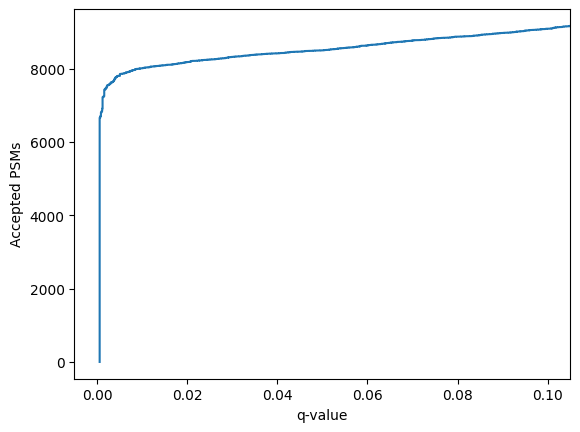

In [34]:
confidence_results.plot_qvalues()
plt.show()

Or to compare the un-rescored PSMs to the rescored PSMs:

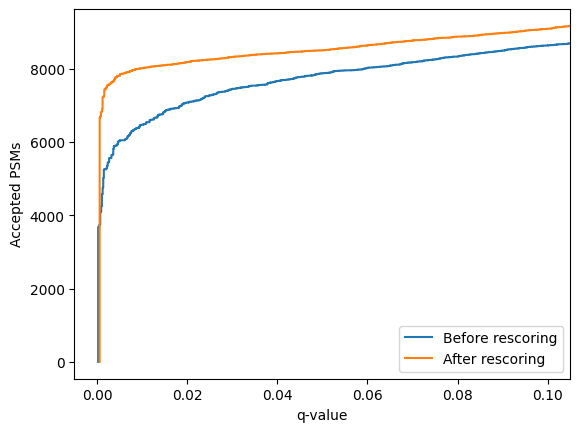

In [35]:
linear_psm_dataset.assign_confidence().plot_qvalues(label="Before rescoring")
confidence_results.plot_qvalues(label="After rescoring")
plt.legend()
plt.show()

Using mokapot directly allows us to quickly generate `LinearPsmDataset` objects with different feature sets, for instance:

- Only basic features
- Basic + MaxQuant-derived features (mimicking a traditional Percolator rescoring run)
- Basic + MaxQuant-derived + MS²PIP features
- Basic + MaxQuant-derived + MS²PIP + DeepLC features


In [36]:
feature_sets = {
    "basic": feature_names["basic"],
    "basic_mq": feature_names["basic"] + feature_names["maxquant"],
    "basic_mq_ms2pip": feature_names["basic"] + feature_names["maxquant"] + feature_names["ms2pip"],
    "basic_mq_ms2pip_deeplc": feature_names["basic"] + feature_names["maxquant"] + feature_names["ms2pip"] + feature_names["deeplc"],
}

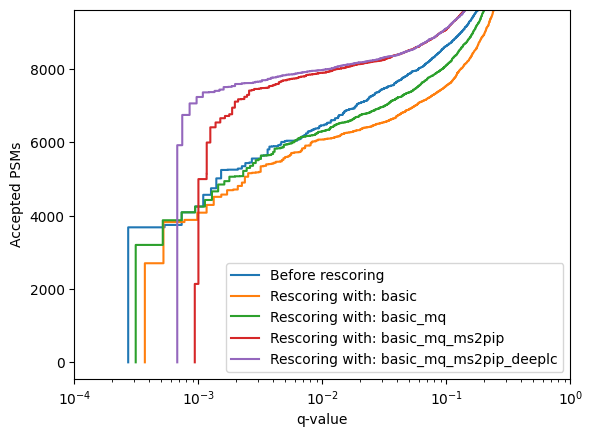

In [37]:
linear_psm_dataset.assign_confidence().plot_qvalues(label="Before rescoring")

for feature_set, features in feature_sets.items():
    linear_psm_dataset = convert_psm_list(psm_list, features)
    confidence_results, models = brew(linear_psm_dataset)
    confidence_results.plot_qvalues(label=f"Rescoring with: {feature_set}")

plt.xscale('log')
plt.xlim(1e-4, 1)
plt.legend()
plt.show()

### Using Mokapot within MS²Rescore

Mokapot can also be used for rescoring with the higher-level integration in MS²Rescore. Simply pass
a PSMList object with rescoring features added to the `rescore` function. Doing so will automatically
convert the PSMList to a Mokapot `LinearPsmDataset`, run the `brew` function, and update the original
PSMList with the new scores, q-values and PEPs.

In [38]:
from ms2rescore.rescoring_engines import mokapot

mokapot.rescore(psm_list)

In [39]:
score_histogram(psm_list.to_dataframe())